# UmojaHack Hackathon
---
Granular information on economic well-being is extremely useful for governments, policy makers, and NGOs. But household surveys that capture this kind of information are expensive and conducted infrequently in many African countries. For this competition we will attempt to create a workaround for this lack of data by building a model able to predict a measure of wealth as measured in household surveys using readily available inputs.

Using data from 18 different countries collected at different times, you must correctly predict the cluster-level estimated wealth measures found from surveys in 7 different countries not covered in the training data. A successful model could be useful for filling in the gaps between the more expensive surveys.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 100, "display.max_rows", 22000)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [50]:
wealth = pd.read_csv("Train.csv")
wealth.head()

Global Human Settlement Layer. Based on data from the GHSL project.

* 'ghsl_water_surface' - the fraction of land within 5km of the cluster that is classified as water surface
* 'ghsl_built_pre_1975' - the fraction of land within 5km of the cluster that is classified as built-up before 1975
* 'ghsl_built_1975_to_1990'
* 'ghsl_built_1990_to_2000',
* 'ghsl_built_2000_to_2014',
* 'ghsl_not_built_up' - land that was never built up
* 'ghsl_pop_density' - population density for the surrounding area (5km radius)

Landcover: based on the Copernicus Global Land Cover Layers (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global)

* 'Landcover_crops_fraction' - the fraction of land within 5km of the cluster that is classified as cropland
* 'landcover_urban_fraction' - the fraction of land within 5km of the cluster that is classified as urban
* 'Landcover_water_permanent_10km_fraction' - the fraction of land within 10km of the cluster that is classified as permanent water
* 'Landcover_water_seasonal_10km_fraction' - the fraction of land within 10km of the cluster that is classified as seasonal water
* 'Nighttime_lights' - a classic indicator of economic activity
* 'Dist_to_capital' - distance to the countries capital
* 'Dist_to_shoreline - distance to the nearest ocean shoreline
* ‘urban_or_rural’: Is the cluster in an urban (‘U’) or rural (‘R’) setting

The target is a derived ‘wealth index’ based on responses in various household surveys. It is on a scale from 0 to 1, with 1 denoting higher wealth. This measure is based on multiple factors such as asset ownership, and gives a single measure across the different surveys and countries that we can use to compare data points in a consistent way. Each row in the dataset corresponds to a cluster of survey responses, and so the Target is a measure of the average wealth for a given cluster of respondents.

In [3]:
wealth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       21454 non-null  object 
 1   country                                  21454 non-null  object 
 2   year                                     21454 non-null  int64  
 3   urban_or_rural                           21454 non-null  object 
 4   ghsl_water_surface                       21454 non-null  float64
 5   ghsl_built_pre_1975                      21454 non-null  float64
 6   ghsl_built_1975_to_1990                  21454 non-null  float64
 7   ghsl_built_1990_to_2000                  21454 non-null  float64
 8   ghsl_built_2000_to_2014                  21454 non-null  float64
 9   ghsl_not_built_up                        21454 non-null  float64
 10  ghsl_pop_density                         21454

## Exploratory Data Analysis
---
* Check the wealth distribution across rural and urban
* Check the wealth distribution across the countries over the years
* Check the wealth distribution across the years

[Text(0.5, 1.0, 'Distribution of the Wealth Index')]

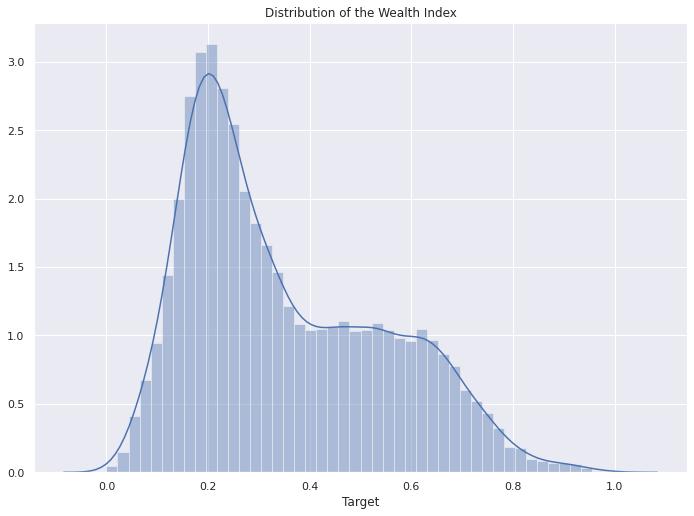

In [4]:
sns.distplot(wealth["Target"]).set(title="Distribution of the Wealth Index")

The distribution is not normal because it is skewed to the left. Therefore, putting this into consideration, we will need to explore a non parametric test for statistical analysis. We also need to keep in mind that the machine learning models to be used, should be those that do not assume normality of data.

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index')]

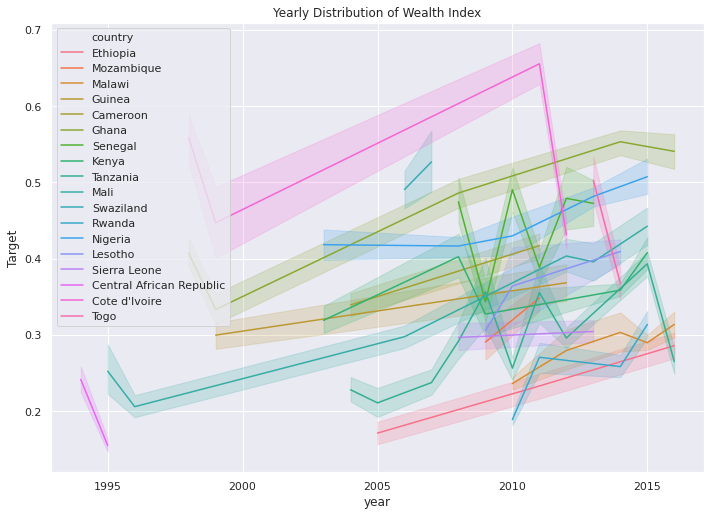

In [51]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth
).set(
    title="Yearly Distribution of Wealth Index (All African Regions)"
)

Looks a little shabby. Let's create African regions for a cleaner view.

In [6]:
# get countries of the different African regions
western = [
    "Benin", "Burkina Faso", "Cape" "Verde", "Côte D'Ivoire", "Gambia", "Ghana", "Guinea", 
    "Guinea-Bissau", "Liberia", "Mali", "Mauritania", "Niger", "Nigeria", "Senegal", "Sierra Leone", "Togo"
]

eastern = [
    "Burundi", "Comoros", "Djibouti", "Eritrea", "Ethiopia", "Kenya", "Madagascar", "Malawi", 
    "Mauritius", "Réunion", "Rwanda", "Seychelles", "Somalia", "Somaliland", "Tanzania", "Uganda"
]

central = [
    "Cameroon", "Central African Republic", "Chad", "Congo Republic - Brazzaville", 
    "Democratic Republic of Congo", "Equatorial Guinea", "Gabon", "São Tomé", "Principe"
]

southern = [
    "Angola", "Botswana", "Lesotho", "Mozambique", "Namibia", "South Africa", "Swaziland", 
    "Zambia", "Zimbabwe"
]

northern = [
    "Algeria", "Egypt", "Libya", "Morocco", "Sudan", "Tunisia", "Western Sahara"
]

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (Western Africa)')]

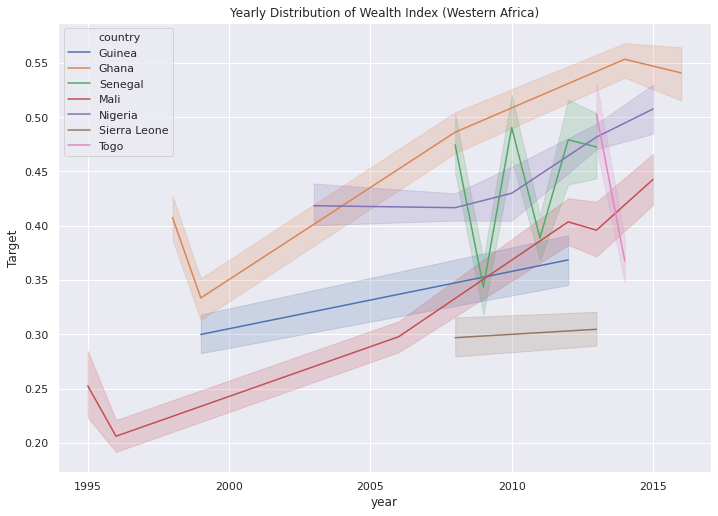

In [52]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(western)]
).set(
    title=("Yearly Distribution of Wealth Index (Western Africa)")
)

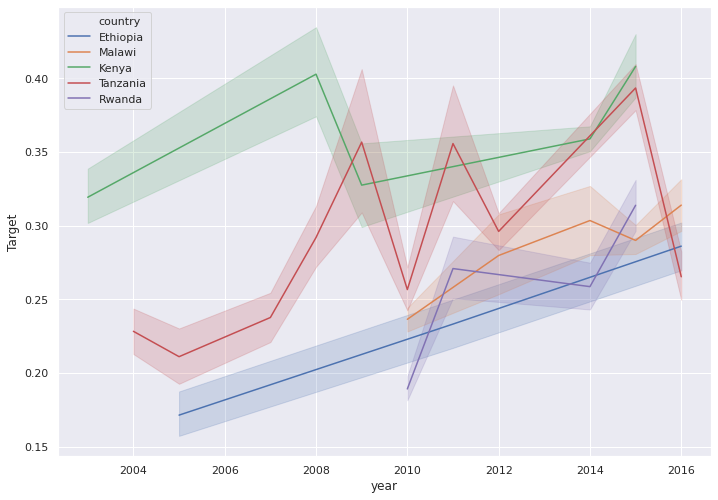

In [8]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(eastern)]
).set(
    title="Yearly Distribution of Wealth Index (Eastern Africa)"
)

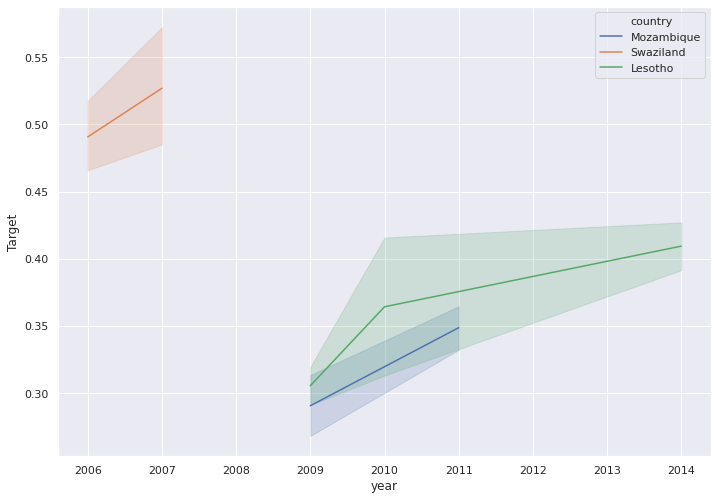

In [9]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(southern)]
).set(
    title="Yearly Distribution of Wealth Index (Southern Africa)"
)

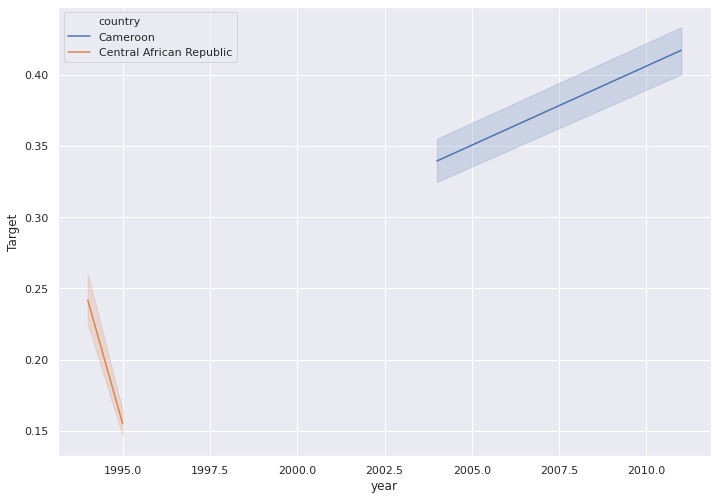

In [10]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(central)]
).set(
    title="Yearly Distribution of Wealth Index (Central Africa)"
)

Based the above visualizations:
* **Western African Region**<br>
Most of the countries have an increase in wealth distribution. For Senegal, it has been experiencing some level of inconsistencies. This could be impacted by certain factors within the country.
---
* **Eastern African Region**<br>
Ethiopia is the only country experiencing a positive trend. The other countries in Eastern Africa seem to be having upwards and downwards trends. 
---
* **Central African Region**<br>
Not enough data has been captured for countries in this region. If anything, the Central African Republic experience a negative trend between the years before 1995.
---
* **Southern African Region**<br>
There is an increase in wealth distribution across the countries in the Southern African Regions.

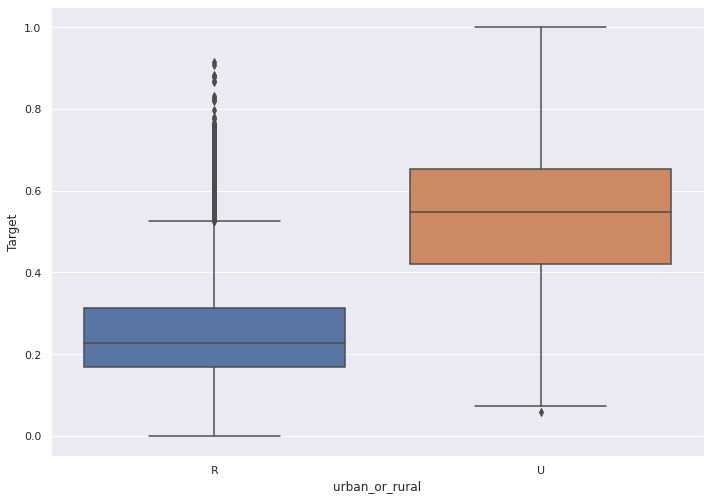

In [11]:
sns.boxplot(x="urban_or_rural", y="Target", data=wealth)

- Data from the rural areas has evident outliers while the urban data is consistent.
- People from urban areas are more wealthy from those from the rural areas.

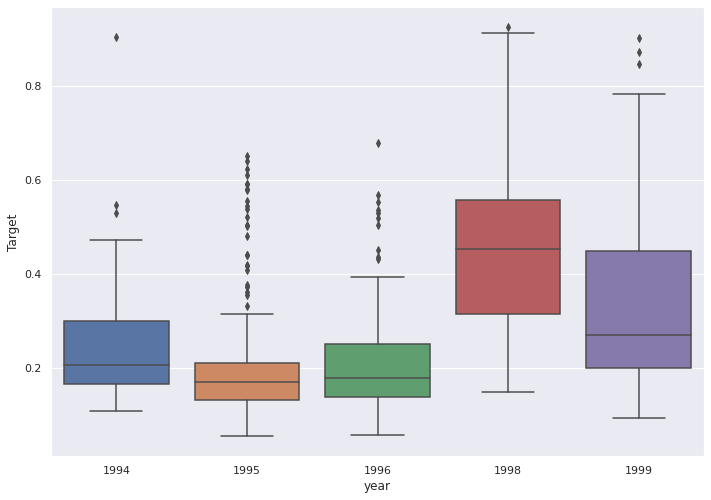

In [12]:
sns.boxplot(x="year", y="Target", data=wealth[wealth["year"] < 2000])

* There was an increase in the wealth distribution in 1998. What happened in 1998?
* In 1995 and 1996, there are significant outliers.

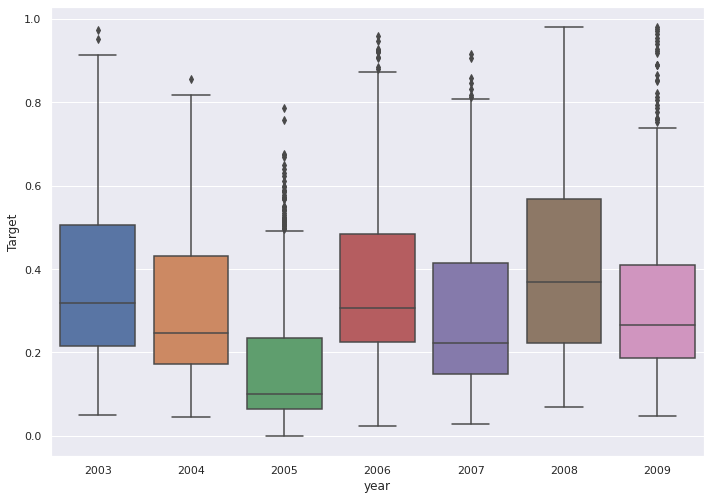

In [13]:
sns.boxplot(x="year", y="Target", data=wealth[(wealth["year"] > 1999) & (wealth["year"] < 2010)])

* There is a dip in the wealth distribution in 2005 across the different countries.
* 2008 had the highest wealth distribution.
* There are also a couple of outliers

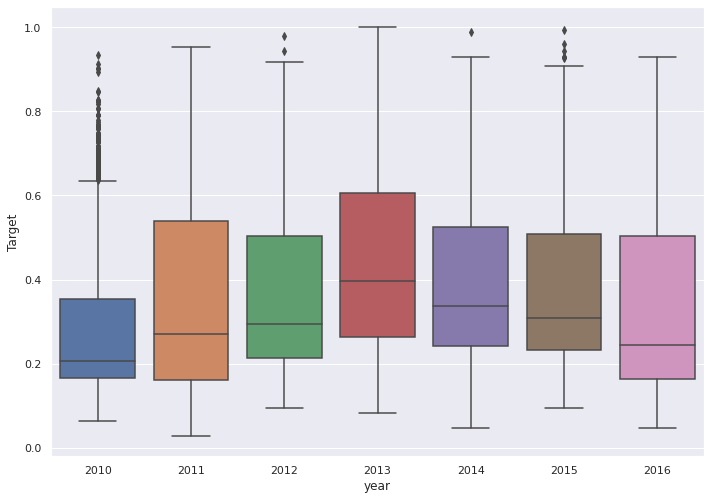

In [14]:
sns.boxplot(x="year", y="Target", data=wealth[wealth["year"] > 2009])

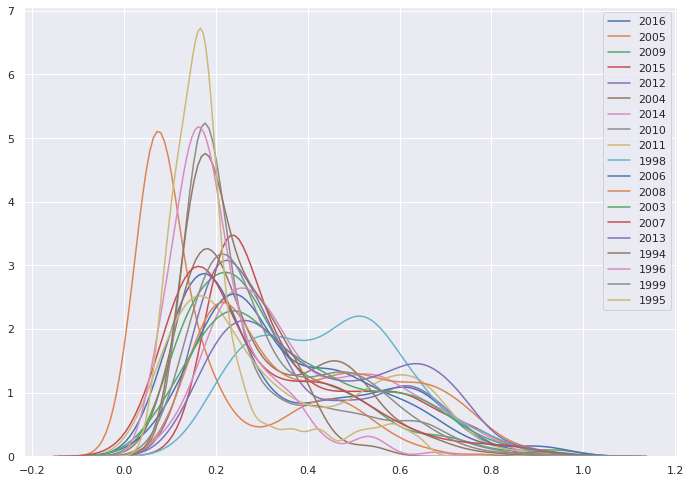

In [15]:
years = wealth["year"].unique()

for year in years:
    subset = wealth[wealth["year"] == year]
    sns.kdeplot(data=subset["Target"], label=year)

In [16]:
wealth.columns

Index(['ID', 'country', 'year', 'urban_or_rural', 'ghsl_water_surface',
       'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
       'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014',
       'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction',
       'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction',
       'landcover_water_seasonal_10km_fraction', 'nighttime_lights',
       'dist_to_capital', 'dist_to_shoreline', 'Target'],
      dtype='object')

The other columns are numerical. That being said, the next step is to check the relationship between those columns with the wealth index and identifiy whether there is any correlation.

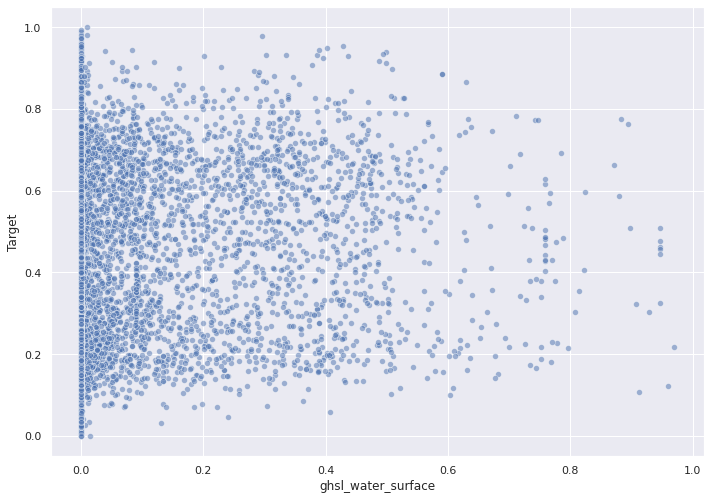

In [17]:
sns.scatterplot(x="ghsl_water_surface", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as water surface is wealthier.

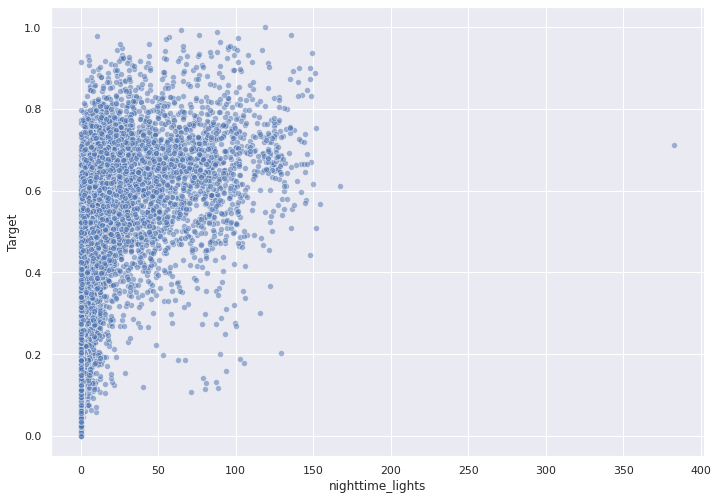

In [18]:
sns.scatterplot(x="nighttime_lights", y="Target", alpha=.5, data=wealth)

Countries with more nighttime lights are wealthier

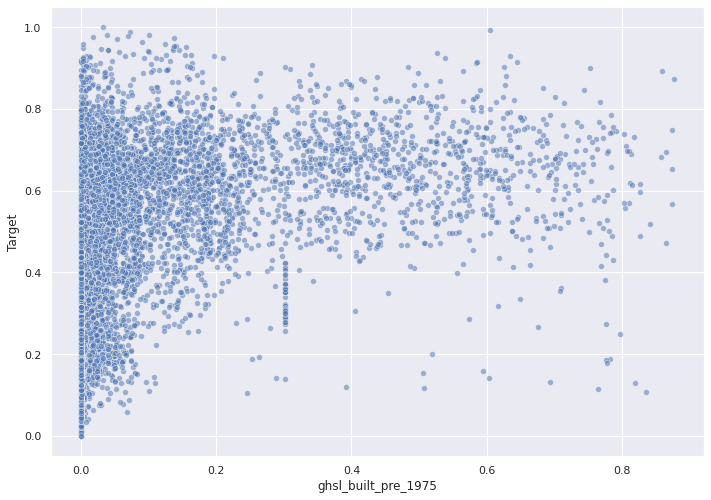

In [19]:
sns.scatterplot(x="ghsl_built_pre_1975", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up before 1975 are wealthier.

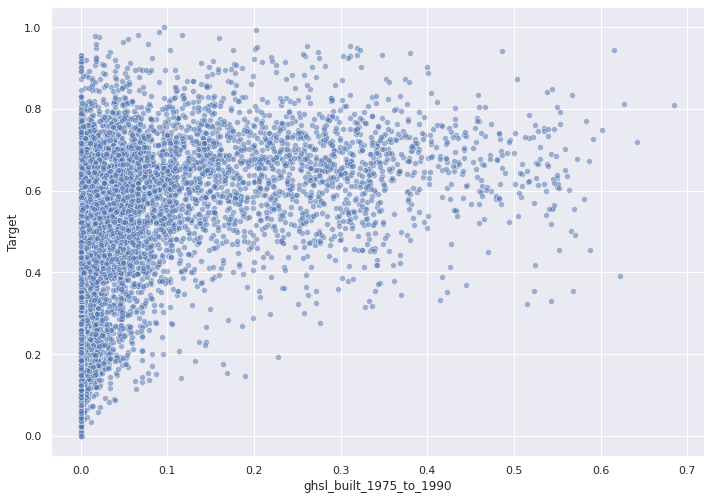

In [20]:
sns.scatterplot(x="ghsl_built_1975_to_1990", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 1975 to 1990 are wealthier.

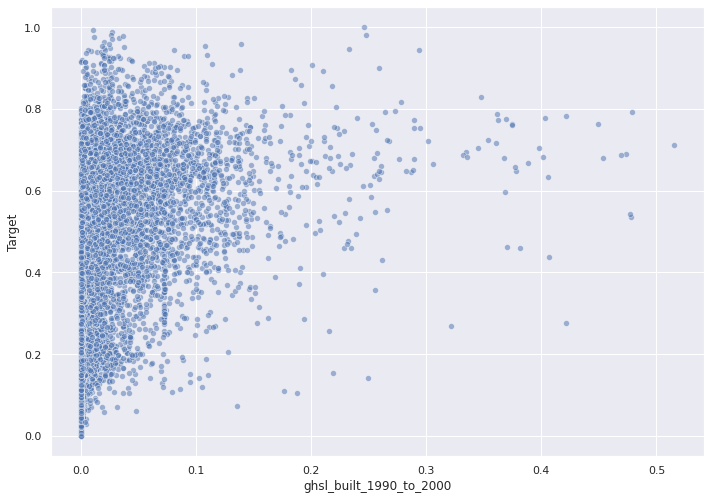

In [21]:
sns.scatterplot(x="ghsl_built_1990_to_2000", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 1990 to 2000 are wealthier.

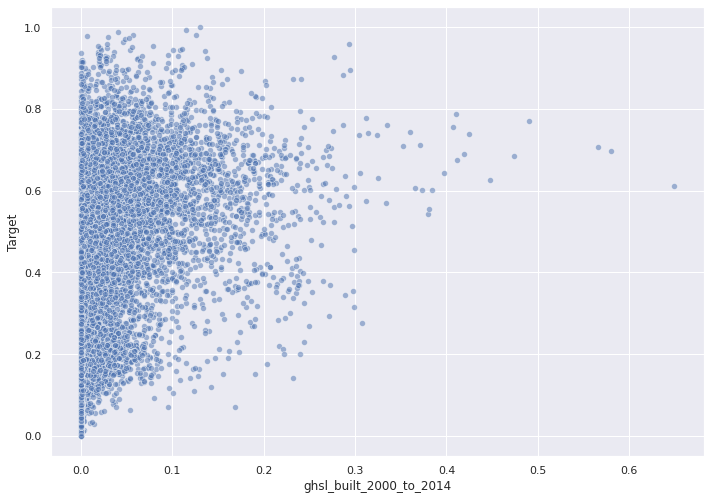

In [22]:
sns.scatterplot(x="ghsl_built_2000_to_2014", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 2000 to 2014 are wealthier.

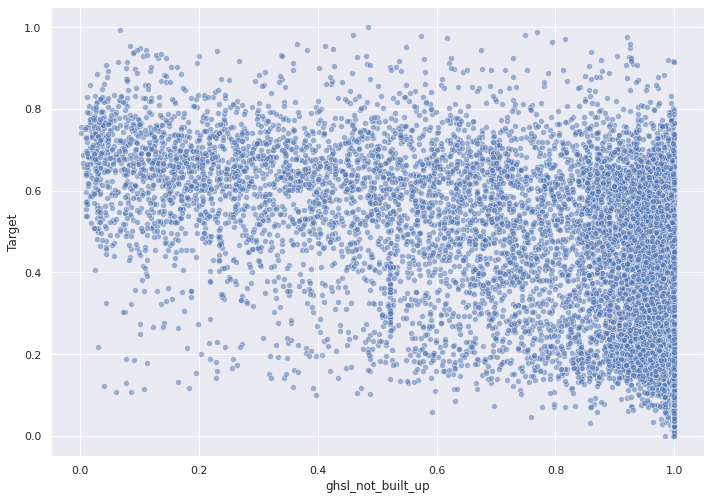

In [23]:
sns.scatterplot(x="ghsl_not_built_up", y="Target", alpha=.5, data=wealth)

The more the country has land that was never built up, the less wealthy they are.

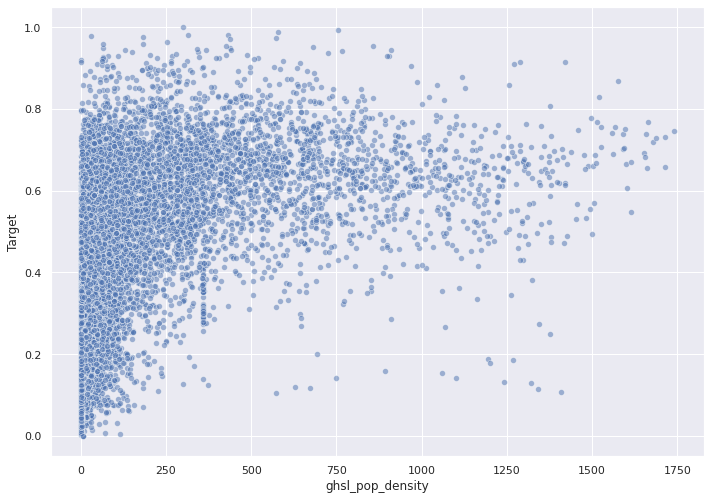

In [24]:
sns.scatterplot(x="ghsl_pop_density", y="Target", alpha=.5, data=wealth)

The higher the population density for the surrounding area is, the more wealthy the country is

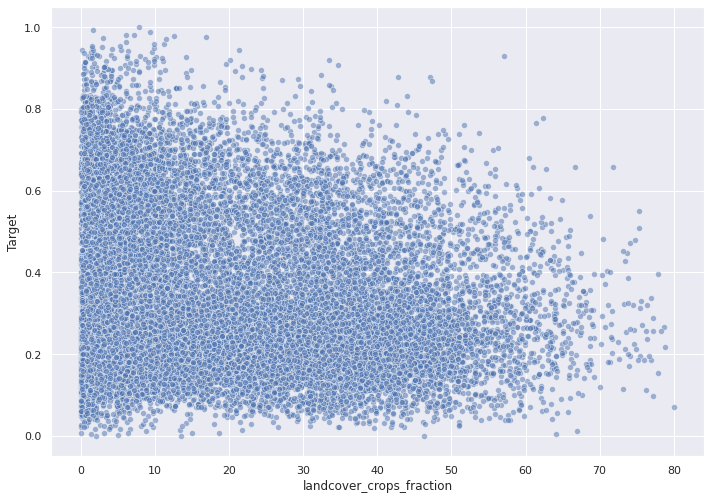

In [25]:
sns.scatterplot(x="landcover_crops_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as cropland are wealthier

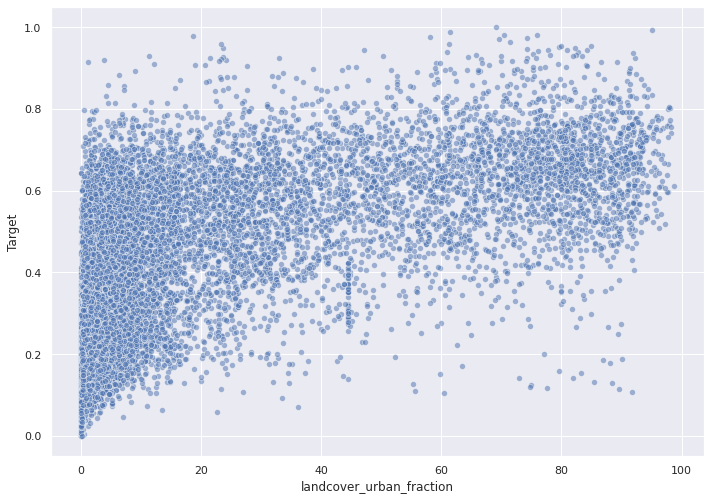

In [26]:
sns.scatterplot(x="landcover_urban_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as urban are wealthier.

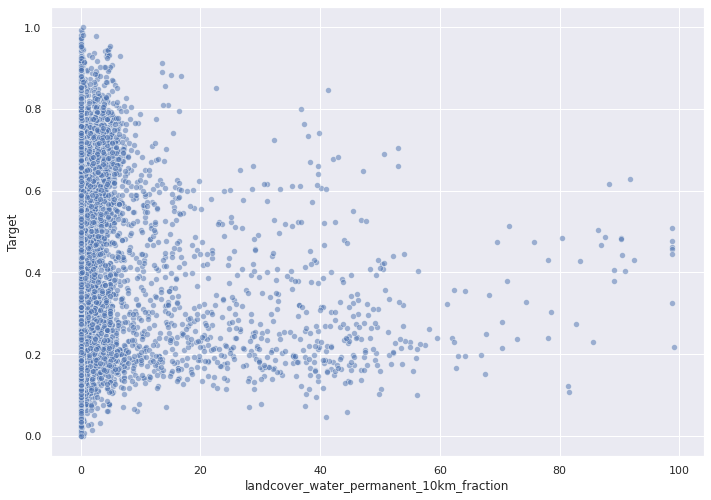

In [27]:
sns.scatterplot(x="landcover_water_permanent_10km_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 10km of the cluster that is classified as permanent water are wealthier.

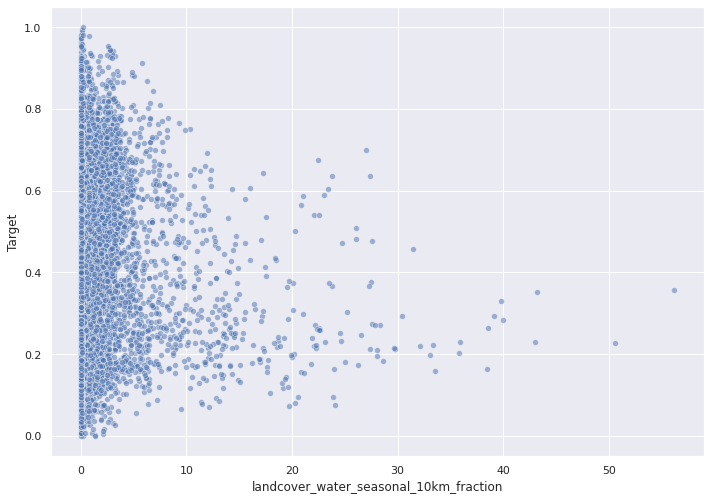

In [28]:
sns.scatterplot(x="landcover_water_seasonal_10km_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 10km of the cluster that is classified as seasonal water are wealthier

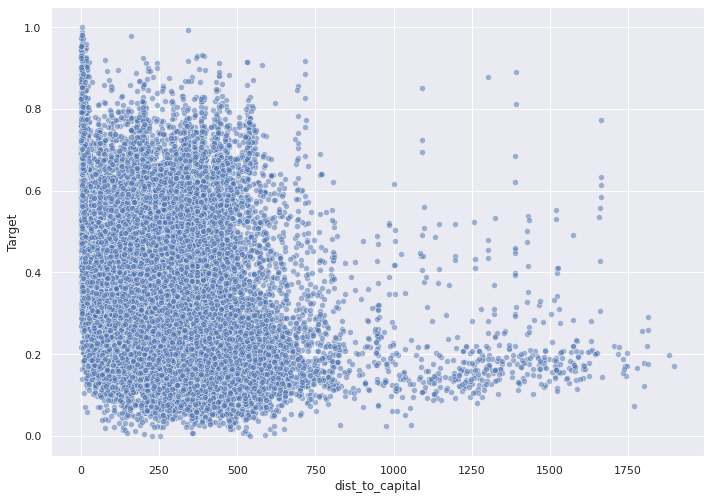

In [29]:
sns.scatterplot(x="dist_to_capital", y="Target", alpha=.5, data=wealth)

Higher distance to the countries capital are less wealthy.

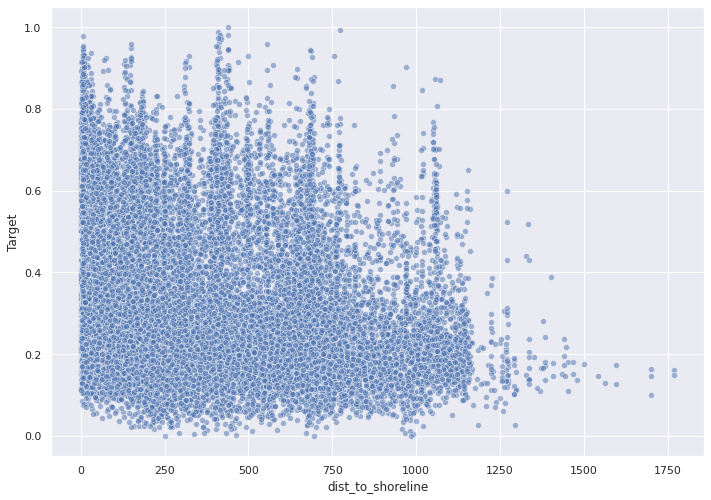

In [30]:
sns.scatterplot(x="dist_to_shoreline", y="Target", alpha=.5, data=wealth)

distance to the nearest ocean shoreline

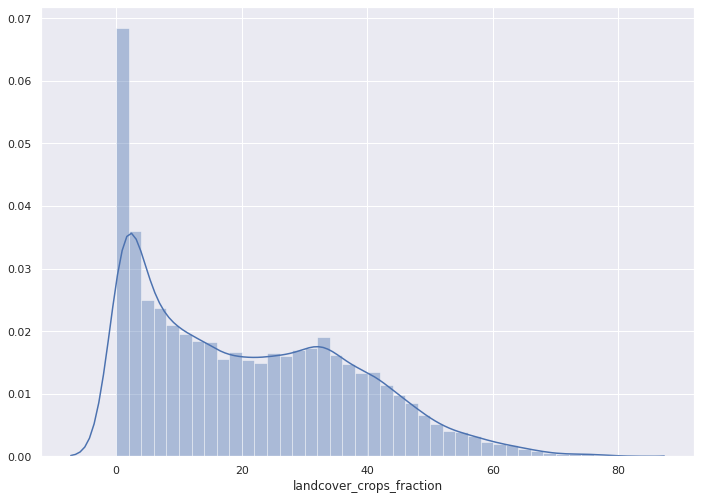

In [31]:
sns.distplot(wealth["landcover_crops_fraction"])

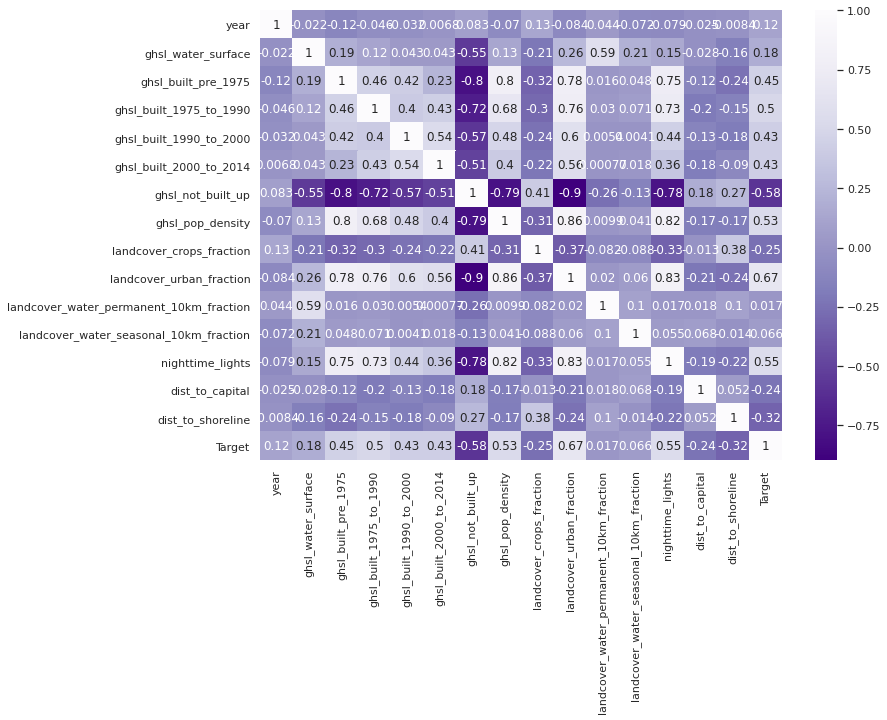

In [32]:
sns.heatmap(wealth.corr(), cbar=True, annot=True, cmap="Purples_r")

In [33]:
wealth["Target"].corr(wealth["year"])

0.11501431032367716

In [34]:
wealth.columns

Index(['ID', 'country', 'year', 'urban_or_rural', 'ghsl_water_surface',
       'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
       'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014',
       'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction',
       'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction',
       'landcover_water_seasonal_10km_fraction', 'nighttime_lights',
       'dist_to_capital', 'dist_to_shoreline', 'Target'],
      dtype='object')

Positive correlation:
* Year<br>
    Target,<br>
    ghsl_water_surface, <br>
    ghsl_built_pre_1975, <br>
    ghsl_built_1975_to_1990, <br>
    ghsl_built_1990_to_2000, <br>
    ghsl_built_2000_to_2014, <br>
    ghsl_pop_density, <br>
    landcover_urban_fraction, <br>
    landcover_water_permanent_10km_fraction, <br>
    landcover_water_seasonal_10km_fraction, <br>
    nighttime_lights

Negative correlation:
* Year <br>
    ghsl_not_built_up, <br>
    landcover_crops_fraction, <br>
    dist_to_capital, <br>
    dist_to_shoreline

## Feature Engineering and selection
---

In [35]:
features = wealth.drop(columns=["ID", "country", "year", "urban_or_rural", "Target"])
target = pd.DataFrame(wealth["Target"])

In [36]:
X, X_test, y, y_test = train_test_split(features, target, test_size=0.33)

In [37]:
# X.score()

In [38]:
print("Predictor Train Features: {}".format(X.shape))
print("Predictor Test Features: {}".format(X_test.shape))
print("Target Train Features: {}".format(y.shape))
print("Target Test Features: {}".format(y_test.shape))

Predictor Train Features: (14374, 14)
Predictor Test Features: (7080, 14)
Target Train Features: (14374, 1)
Target Test Features: (7080, 1)


In [39]:
rf = RandomForestRegressor()

In [40]:
rf.fit(X, y)

<ipython-input-40-81a7c6de9acf>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestRegressor()

In [41]:
rf.predict(X_test)

array([0.2033837 , 0.1981772 , 0.18725156, ..., 0.42749764, 0.67189688,
       0.49039955])

In [42]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def training_and_evaluate(model):
    model.fit(X, y)
    
    model_pred = model.predict(X_test)
    
    model_mae = mae(y_test["Target"], model_pred)
    
    return model_mae

In [43]:
# lr_mae = training_and_evaluate(lr)
rf_mae = training_and_evaluate(rf)
# dt_mae = training_and_evaluate(dt)

# print("Logistic Regression Mean Absolute Error: {}".format(lr_mae))
print("Random Forest Mean Absolute Error: {}".format(rf_mae))
# print("Decision Tree Mean Absolute Error: {}".format(dt_mae))pd

<ipython-input-42-b71edfe8d9ef>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


Random Forest Mean Absolute Error: 0.07994633013788364


In [44]:
wealth[["ID", "Target"]].head()

ID    Target
0  ID_AAIethGy  0.132783
1  ID_AAYiaCeL  0.004898
2  ID_AAdurmKj  0.097320
3  ID_AAgNHles  0.304107
4  ID_AAishfND  0.605328

In [45]:
wealthTest = pd.read_csv("Test.csv")
wealthTest.head()

ID                       country  year urban_or_rural  \
0  ID_AAcismbB  Democratic Republic of Congo  2007              R   
1  ID_AAeBMsji  Democratic Republic of Congo  2007              U   
2  ID_AAjFMjzy                        Uganda  2011              U   
3  ID_AAmMOEEC                  Burkina Faso  2010              U   
4  ID_ABguzDxp                        Zambia  2007              R   

   ghsl_water_surface  ghsl_built_pre_1975  ghsl_built_1975_to_1990  \
0            0.000000             0.000000                 0.000000   
1            0.000000             0.004239                 0.000238   
2            0.007359             0.525682                 0.132795   
3            0.000000             0.000089                 0.000036   
4            0.000000             0.000138                 0.000623   

   ghsl_built_1990_to_2000  ghsl_built_2000_to_2014  ghsl_not_built_up  \
0                 0.000523                 0.000131           0.999347   
1                 0.001227                 0.002860           0.991437   
2                 0.095416                 0.042375           0.196373   
3                 0.001519                 0.001358           0.996997   
4                 0.000615                 0.002961           0.995663   

   ghsl_pop_density  landcover_crops_fraction  landcover_urban_fraction  \
0          0.660758                  0.990942                  0.132264   
1          6.441547                  5.461365                  0.452400   
2        587.516458                  2.881811                 87.387991   
3         35.141762                 33.878927                  4.166437   
4          3.442449                 33.491994                  3.437129   

   landcover_water_permanent_10km_fraction  \
0                                 0.069055   
1                                 0.000000   
2                                 3.248483   
3                                 0.000000   
4                                 0.133563   

   landcover_water_seasonal_10km_fraction  nighttime_lights  dist_to_capital  \
0                                0.032627          0.000000      1249.294720   
1                                0.000000          0.000000       821.019579   
2                                3.950374         60.070041         3.620455   
3                                0.130727          1.333999       109.493969   
4                                0.128997          0.502203       133.643319   

   dist_to_shoreline  
0        1364.592100  
1        1046.028681  
2         906.057334  
3         775.139189  
4         835.591501

In [46]:
submission = pd.read_csv("SampleSubmission.csv")
submission.head()

ID  Target
0  ID_AAcismbB       0
1  ID_AAeBMsji       0
2  ID_AAjFMjzy       0
3  ID_AAmMOEEC       0
4  ID_ABguzDxp       0

In [47]:
pred = pd.DataFrame(rf.predict(wealthTest[features.columns])).rename(columns={0: "Target"})
pred.head()

Target
0  0.133242
1  0.163964
2  0.599605
3  0.273131
4  0.251713

In [48]:
submission["Target"] = rf.predict(wealthTest[features.columns])
submission.head()

ID    Target
0  ID_AAcismbB  0.133242
1  ID_AAeBMsji  0.163964
2  ID_AAjFMjzy  0.599605
3  ID_AAmMOEEC  0.273131
4  ID_ABguzDxp  0.251713

In [49]:
# submission.to_csv("Initial_Submission.csv", index=False)